In [23]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy import interpolate
from astropy.convolution import convolve, Box1DKernel,convolve_fft, Gaussian1DKernel
from astropy.modeling import models, fitting

%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

20190529 Looking at LRS2 data. Rough here, will probably turn into a script to make coadded spectra.

In [74]:
runs = glob.glob('programs/ut*')

In [75]:
runs

['programs/ut19-2-003', 'programs/ut18-1-001', 'programs/ut19-1-003']

In [76]:
run3 = runs[0]

In [77]:
spectra = glob.glob(run3+'/spectrum*')

In [78]:
hdul = fits.open(spectra[0])

In [79]:
hdul.info()

Filename: programs/ut19-2-003/spectrum_20190425_0000007_exp10_orange.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     162   (2064, 6)   float64   


In [80]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2064                                                  
NAXIS2  =                    6                                                  
EXTEND  =                    T                                                  
DATE    = '2019-04-25T07:11:23.860585'                                          
DATE-OBS= '2019-04-25'                                                          
TELESCOP= 'het     '                                                            
INSTRUME= 'lrs2    '                                                            
OBJECT  = 'GJ436_056_W'                                                         
OBSERVER= ''                                                                    
TELRA   = '+11:43:01.4'     

In [81]:
stars  = []
for spectrum in spectra:
    star = fits.getheader(spectrum,0)['QOBJECT']
    stars.append(star)
stars = np.unique(stars)
stars

array(['GJ436', 'GJ649'], dtype='<U5')

In [83]:
#star = stars[1]
uvspec = glob.glob(run3+'/*uv.fits')
ospec = glob.glob(run3+'/*orange.fits')

In [12]:
def spectra_adder(fluxes, errors):
    """
    combines the flux at each overlap
    """
    weight_f = np.average(fluxes, axis =0, weights=(1/errors))
    weight_e = np.average((weight_f - fluxes)**2, axis=0, weights = (1/errors))**0.5
    return weight_f, weight_e

In [19]:
stars[1]

'GJ649'

In [111]:
fs = []
es = []
for sp in ospec:
      if fits.getheader(sp,0)['QOBJECT'] == stars[1]:
        #print(sp)
        data = fits.getdata(sp,0)
        fs.append(data[1])
        es.append(data[3]) #2 is sky
        w = data[0] #fixed w scale, no need to interpolate
f, e = spectra_adder(np.array(fs),np.array(es))

plt.plot(w,f)        

FileNotFoundError: [Errno 2] No such file or directory: 'programs/ut19-2-003/spectrum_20190425_0000007_exp10_orange.fits'

In [26]:
ow, of, oe, = w, f, e

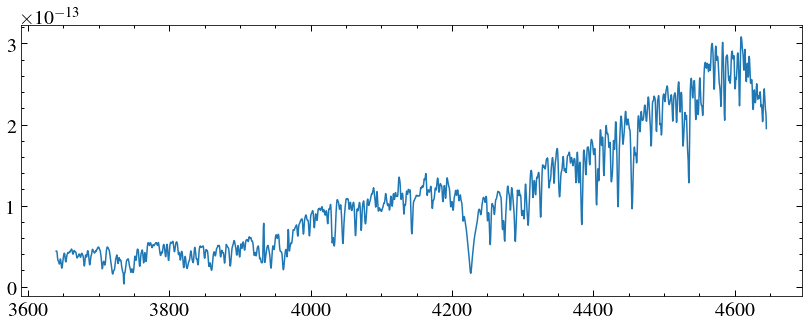

In [27]:
fs = []
es = []
for sp in uvspec:
      if fits.getheader(sp,0)['QOBJECT'] == stars[1]:
        #print(sp)
        data = fits.getdata(sp,0)
        fs.append(data[1])
        es.append(data[3]) #2 is sky
        w = data[0] #fixed w scale, no need to interpolate
f, e = spectra_adder(np.array(fs),np.array(es))

plt.plot(w,f)        

In [28]:
uw, uf, ue = w, f, e

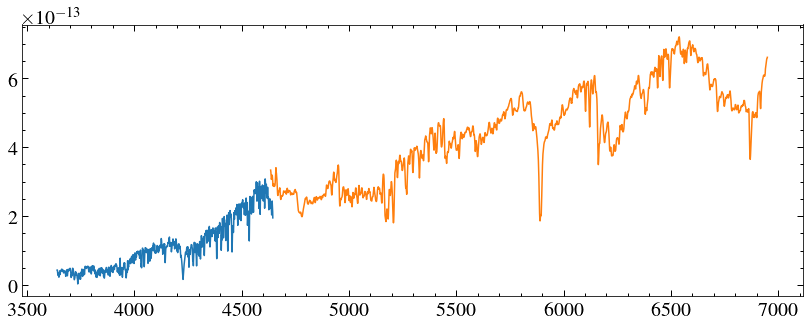

In [31]:
plt.plot(uw, uf)
plt.plot(ow, of)
#plt.xlim(4600, 4800)

(Whispers) how is the absolute flux calibration?

In [32]:
phottab = 'gj649_phot.vot'
from astropy.io.votable import parse
votable = parse(phottab)
table = votable.get_first_table()
data = table.array

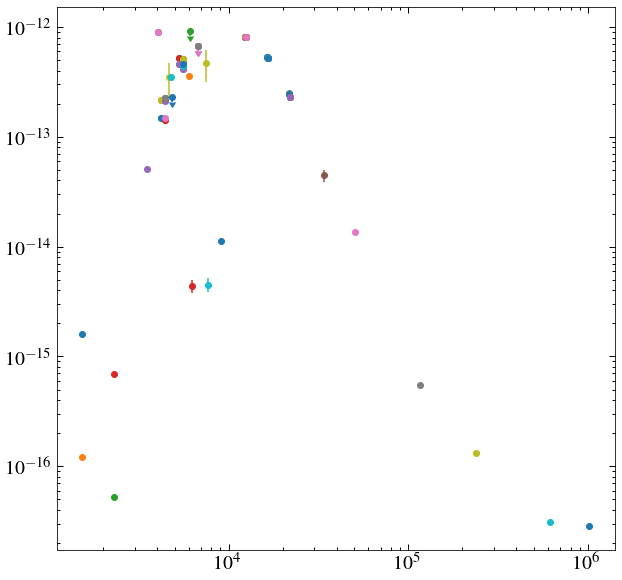

In [41]:
c = const.c.value
masked_data = data.data
w = []
f = []
e = []
filters = []
for i in range(len(masked_data['sed_freq'])):
    w.append(10.*c/masked_data['sed_freq'][i])
    f.append(2.99792458E-05*masked_data['sed_flux'][i]/(w[i]**2))
    e.append((masked_data['sed_eflux'][i]*f[i])/masked_data['sed_flux'][i])
    filters.append(masked_data['sed_filter'][i])
#print(w,f,e)
w, f ,e = np.array(w), np.array(f), np.array(e)
arr1inds = w.argsort()
w = w[arr1inds]
f = f[arr1inds]
e = e[arr1inds]


plt.figure('sed', figsize=(10,10))
for i in range(len(w)):
    if e[i] !=0.0:
        plt.errorbar(w[i], f[i], yerr=e[i], marker='o', ls='none')
    else:
        plt.errorbar(w[i], f[i], yerr=f[i]*0.1, marker='o', ls='none', uplims=True)
plt.yscale('log')
plt.xscale('log')

In [42]:
mask = (w > uw[0]) & (w < ow[-1]) 

In [43]:
w, f, e = w[mask], f[mask], e[mask]

<ErrorbarContainer object of 3 artists>

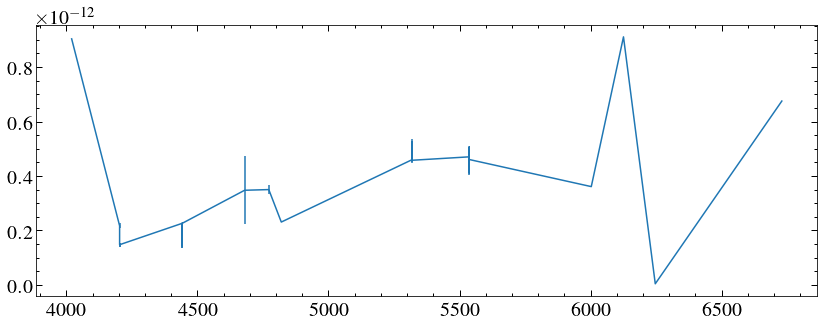

In [45]:
plt.errorbar(w,f, yerr=e)

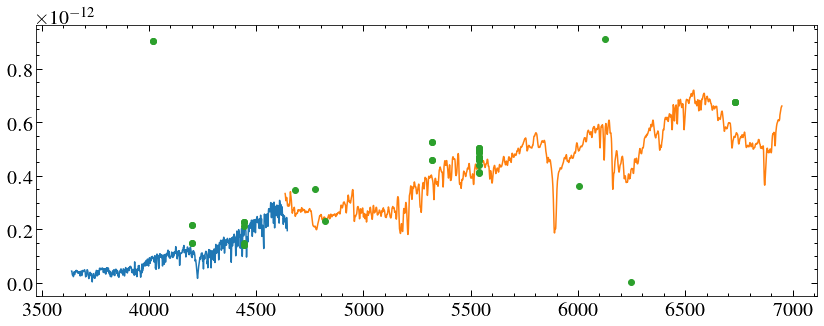

In [48]:
plt.plot(uw, uf)
plt.plot(ow, of)
plt.scatter(w,f, c='C2', zorder=10)

It's...it's alright. Photometry is all over the place, that's more of a problem. What about the STIS spectrum? (Is there one yet)? Yes.

In [51]:
stisccd = '../MegaMUSCLES/GJ_649/HST/STIS/odlm12010_sx1.fits'

In [52]:
data = fits.getdata(stisccd,1)

In [53]:
ws, fs = data['WAVELENGTH'], data['FLUX']

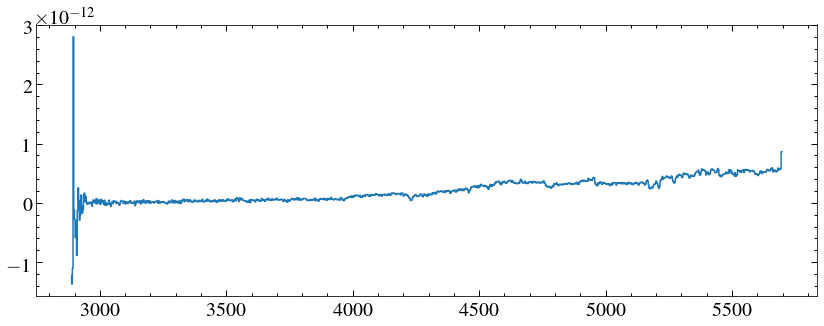

In [54]:
plt.step(ws, fs)

In [55]:
mask = ws > 3500
ws, fs = ws[mask], fs[mask]

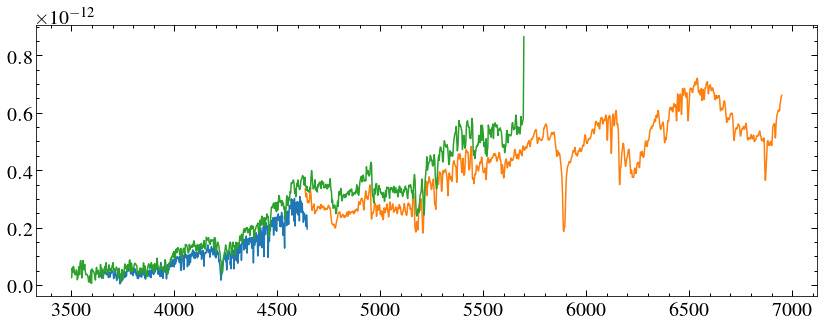

In [56]:
plt.plot(uw, uf)
plt.plot(ow, of)
plt.plot(ws, fs)

Bit concerned about the relative flux at the blue end...

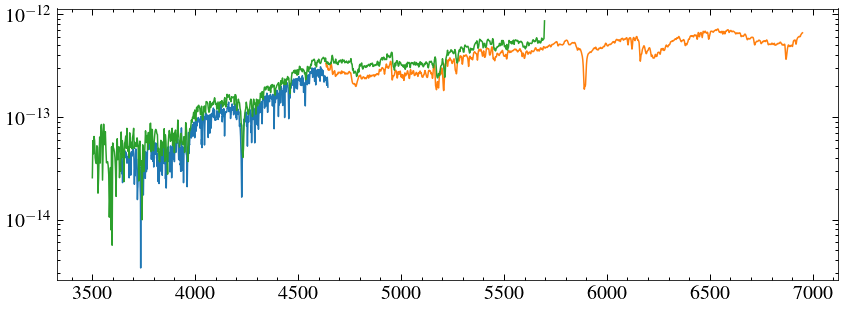

In [57]:
plt.plot(uw, uf)
plt.plot(ow, of)
plt.plot(ws, fs)
plt.yscale('log')

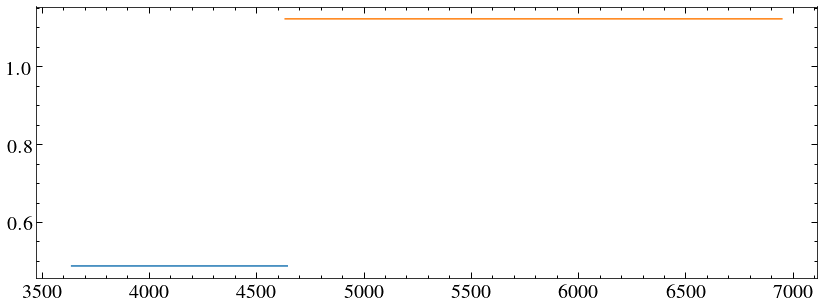

In [58]:
plt.plot(uw[:-1], np.diff(uw))
plt.plot(ow[:-1], np.diff(ow))

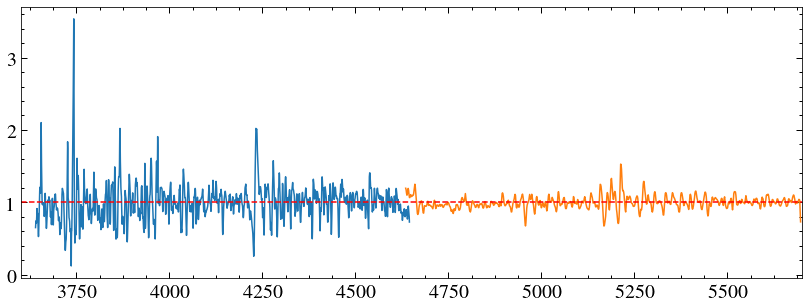

In [68]:
for wi, fi in zip([uw, ow],[uf, of]):
    mask = (ws > wi[0]) & (ws < wi[-1])
    newf = interpolate.interp1d(ws[mask], fs[mask], fill_value ='extrapolate')(wi[wi < ws[-1]])
    scale = fi[wi < ws[-1]]/newf
    plt.plot(wi[wi < ws[-1]], scale/np.mean(scale))
plt.xlim(3600,5700)
plt.axhline(1, ls ='--', c='r')

Great, looks line we can get away with a fixed normfac

In [110]:
for wi, fi in zip([uw, ow],[uf, of]):
    smask = (ws > wi[0]) & (ws < wi[-1])
    lmask = (wi < ws[-1])
    lf = np.trapz(fi[lmask], wi[lmask])
    sf = np.trapz(fs[smask], ws[smask])
    normfac = sf/lf
    print(normfac)
    plt.plot(wi, fi*normfac)

plt.step(ws[:-1], fs[:-1])

TypeError: only integer scalar arrays can be converted to a scalar index

Perfect.What about the overlap?

1.299439270267638
1.2362533847921378


(4500, 4800)

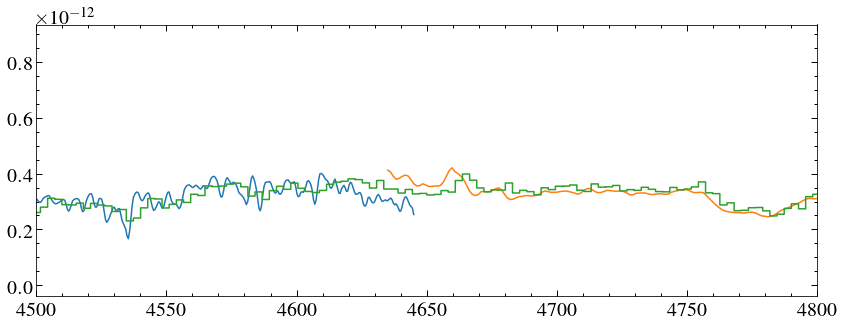

In [73]:
for wi, fi in zip([uw, ow],[uf, of]):
    smask = (ws > wi[0]) & (ws < wi[-1])
    lmask = (wi < ws[-1])
    lf = np.trapz(fi[lmask], wi[lmask])
    sf = np.trapz(fs[smask], ws[smask])
    normfac = sf/lf
    print(normfac)
    plt.plot(wi, fi*normfac)

plt.step(ws[:-1], fs[:-1])
plt.xlim(4500, 4800)

It's very small. Could just pick one or the other, easer than averaging. UV has higher res?

Going to turn this into a script, LRS2_add.py  

Trying the other star, causing problems in the script...

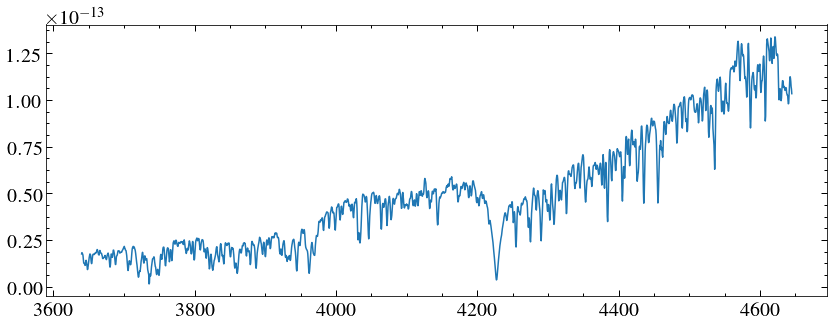

In [84]:
fs = []
es = []
for sp in uvspec:
      if fits.getheader(sp,0)['QOBJECT'] == stars[0]:
        #print(sp)
        data = fits.getdata(sp,0)
        fs.append(data[1])
        es.append(data[3]) #2 is sky
        w = data[0] #fixed w scale, no need to interpolate
f, e = spectra_adder(np.array(fs),np.array(es))

plt.plot(w,f)     

Ok it exists, must be a script issue. Fixed.

New issue, older spectra don't have QOBJECT.

In [85]:
runs

['programs/ut19-2-003', 'programs/ut18-1-001', 'programs/ut19-1-003']

In [86]:
hdul.close()

In [88]:
hdul = fits.open(runs[1]+'/'+os.listdir(runs[1])[0])

In [89]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2064                                                  
NAXIS2  =                    6                                                  
EXTEND  =                    T                                                  
DATE    = '2018-03-16T11:20:19'                                                 
DATE-OBS= '2018-03-16'                                                          
TELESCOP= 'het     '                                                            
INSTRUME= 'lrs2    '                                                            
OBJECT  = 'GJ699_056_E'                                                         
OBSERVER= ''                                                                    
DATAFORM= 'CAMRA   '        

Ok, sadly it looks like it will have to be 'OBJECT'

To do - move all data to one directory, no point splitting it up by program. Put stuff on github. Sort spectra by date.

20190531 Got some new data. GJ649 has a "W" and "E" observation, wonder how they're different. LHS 2686 is flaring strongly, check sub-exposures.

In [96]:
datafiles = glob.glob('spectra/*')

In [97]:
gj649_spec = glob.glob('spectra/GJ649*')
gj649_spec

['spectra/GJ649_056_W_LRS2_orange.ecsv',
 'spectra/GJ649_056_E_LRS2_uv.ecsv',
 'spectra/GJ649_056_E_LRS2_orange.ecsv',
 'spectra/GJ649_056_W_LRS2_uv.ecsv']

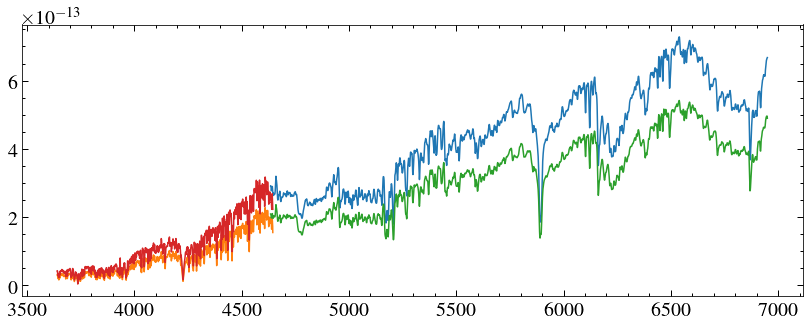

In [98]:
for s in gj649_spec:
    data = Table.read(s)
    plt.plot(data['WAVELENGTH'], data['FLUX'])

Slight offset in flux calibration, coadd should be fine.

In [101]:
from lrs2_add import stars_finder as stars_finder

In [104]:
stars = stars_finder('data/')
stars

array(['GJ1127_056_E', 'GJ1127_066_E', 'GJ1172_056_E', 'GJ1172_066_E',
       'GJ15A_056_W', 'GJ436_056_W', 'GJ649_056_E', 'GJ649_056_W',
       'GJ699_056_E', 'L980_5_056_E', 'L980_5_056_W', 'LHS2686_056_W'],
      dtype='<U13')

In [105]:
star = stars[-1]

(3600, 7100)

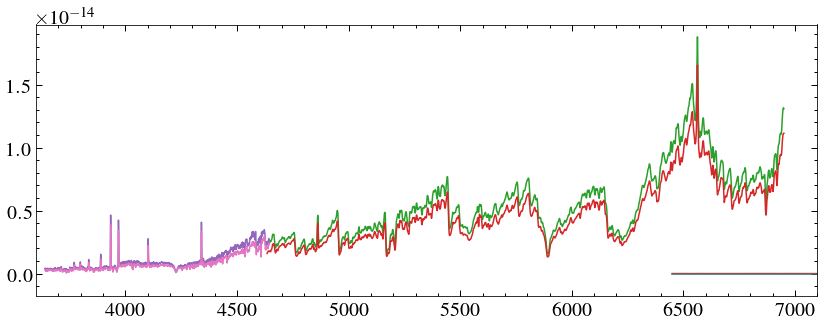

In [109]:
for sp in glob.glob('data/spectrum*'):
    if fits.getheader(sp,0)['OBJECT'] == star:
        data = fits.getdata(sp,0)
        plt.plot(data[0], data[1])
plt.xlim(3600, 7100)

No real difference :(

In [112]:
print(normfac)

1.2362533847921378
